## Home Credit Default Risk 
- 銀行客戶貸款償還能力分析
- 二分類問題
- TARGET 1: 不還錢 ; 0: 會還錢

In [2]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 載入訓練資料集
train = pd.read_csv('./data/Home Credit Default Risk/application_train.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [4]:
# 載入測試資料集
test = pd.read_csv('./data/Home Credit Default Risk/application_test.csv')
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,...,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,...,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0

In [5]:
# 合併 train & test 資料集
y_train = train['TARGET']
X = pd.concat([train, test], ignore_index = True)


In [6]:
# 確認資料特徵類型
print(f'\ntrain shape: {train.shape}')
print(f'\ntest shape: {test.shape}')


train shape: (307511, 122)

test shape: (48744, 121)


#### 檢查缺失值

In [7]:
def missing_value_table(df):
    
    # 計算所有的缺失值
    mis_val = df.isnull().sum()
    
    # 佔 % 比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 合併
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 給予合併的表格 每個column各一個新名字
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    
    # 剔除沒有缺失值的 並 排序
    # 判斷所有數據中的第一 row .iloc[:,1]!=0] 不等於 0的 
    # .iloc[:,1] 代表Missing value 那個 column
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('% of total values',ascending=True)
    
    return mis_val_rename

# 展示缺失值
missing_value_table(X)[:10]

,Missing values,% of total values
DAYS_LAST_PHONE_CHANGE,1,0.000281
CNT_FAM_MEMBERS,2,0.000561
AMT_ANNUITY,36,0.010105
AMT_GOODS_PRICE,278,0.078034
EXT_SOURCE_2,668,0.187506
DEF_60_CNT_SOCIAL_CIRCLE,1050,0.294733
OBS_60_CNT_SOCIAL_CIRCLE,1050,0.294733
DEF_30_CNT_SOCIAL_CIRCLE,1050,0.294733
OBS_30_CNT_SOCIAL_CIRCLE,1050,0.294733
NAME_TYPE_SUITE,2203,0.618377


### Object 類型處理
- 類別大於三個用ONE-HOT ENCODING
- 類別小於三個用LABEL ENCODING
- 使用.apply()函數對 nunique 唯一值做記數

In [8]:
# 確認一下資料類型
X.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

In [9]:
# 做ENCODING前 先看看個特徵有多少個非重複的值
X.select_dtypes('object').apply(pd.Series.nunique,axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
# 針對特徵數小魚等於2的特徵 做 labelencoding

le = LabelEncoder()
for col in X:
    if X[col].dtype == 'object':
        if len(list(X[col].unique()))<=2:
            le.fit(X[col])
            X[col]=le.transform(X[col])
            
X.shape            

(356255, 122)

In [11]:
# 剩餘的 object type 做 one-hot encoding
# pd.get_dummies() 會默認自動將他覺得合適的給轉了

X = pd.get_dummies(X)
X.shape

(356255, 243)

### EDA (Exploratory Data Analysis) 探索式資料分析
- 年齡分析: 
  - 平均年齡43歲，看來年紀大的人貸款挺多的
- 工作年資: 
  - 竟然有一個365243年資的，發現離群值

In [13]:
# 先把標籤拿出來
train_labels = X['TARGET']
# 觀察年紀特徵: 數字代表他活了多少天
X['DAYS_BIRTH'][:5]

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

In [14]:
# 年齡有問題 先做絕對值然後除365轉成年紀
X['DAYS_BIRTH'] = abs(X['DAYS_BIRTH'])/365

# 發現年紀是負數 將她轉換為正常年紀，平均年齡43歲 年紀都挺大
X['DAYS_BIRTH'].describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [15]:
# 發現年資有負數，給他取絕對值
X['DAYS_EMPLOYED'] = abs(X['DAYS_EMPLOYED'])

# 工作年資, 發現離群值
(X['DAYS_EMPLOYED']).describe()

count    356255.000000
mean      68240.792834
std      139858.346025
min           0.000000
25%         949.000000
50%        2243.000000
75%        5773.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

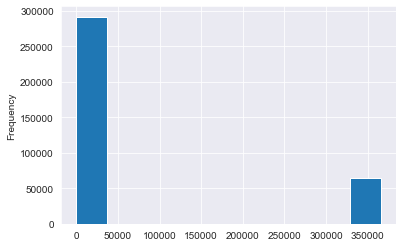

In [16]:
# 看一下工作年資圖, 發現有一個超大的值, 350000
X['DAYS_EMPLOYED'].plot.hist()
plt.show()

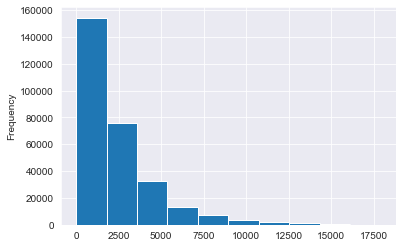

In [17]:
# 發現離群值
X['DAYS_EMPLOYED_ANOM'] = X['DAYS_EMPLOYED'] == 365243

# 將離群值替換成nan, 反正等等會做缺失值處理
X['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)
X['DAYS_EMPLOYED'].plot.hist()
plt.show()

In [18]:
correlations = X.corr()['TARGET'].sort_values()
correlations.head()

EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_BIRTH      -0.078239
DAYS_EMPLOYED   -0.074958
Name: TARGET, dtype: float64

In [19]:
# 再看看最相關的
correlations.tail()[::-1]

TARGET                         1.000000
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
NAME_INCOME_TYPE_Working       0.057481
DAYS_LAST_PHONE_CHANGE         0.055218
Name: TARGET, dtype: float64

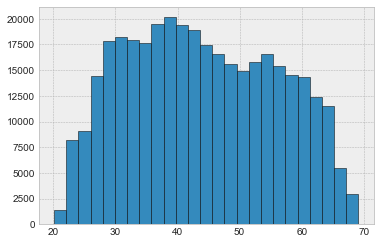

In [21]:
# 看一下年齡的分布
plt.style.use('bmh')

plt.hist(X['DAYS_BIRTH'], edgecolor='k', bins=25)
plt.show()

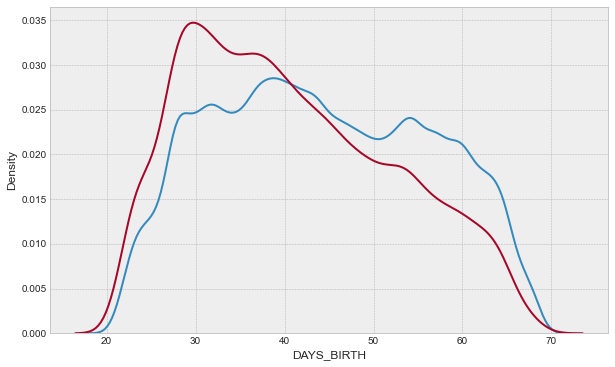

In [22]:
# 發現年輕人比較還不出錢 (1:不會還款)
plt.figure(figsize=(10,6))

# KDEPLOT (核密度估計圖) 要加 .loc ==> 才可定位到指定目標
sns.kdeplot(X.loc[X['TARGET']==0,'DAYS_BIRTH'], label = 'TARGET == 0') # 藍
sns.kdeplot(X.loc[X['TARGET']==1,'DAYS_BIRTH'], label = 'TARGET == 1') # 紅
plt.show()

In [23]:
# 只針對 target 跟 年紀 做一個 dataframe
age_data = X[['TARGET','DAYS_BIRTH']]

# 將年齡天數做一個新特徵為 year
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']

# 做年齡切分 ,從20到70,分為11個群組bins
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1.0,25.920548,25.920548,"(25.0, 30.0]"
1,0.0,45.931507,45.931507,"(45.0, 50.0]"
2,0.0,52.180822,52.180822,"(50.0, 55.0]"
3,0.0,52.068493,52.068493,"(50.0, 55.0]"
4,0.0,54.608219,54.608219,"(50.0, 55.0]"


In [24]:
# 判斷不同年齡段
# Target數字越大, 代表越不可能還錢, 得到越年輕越不會還錢

age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,23.392817,23.392817
"(25.0, 30.0]",0.111436,27.831653,27.831653
"(30.0, 35.0]",0.102814,32.483229,32.483229
"(35.0, 40.0]",0.089414,37.556413,37.556413
"(40.0, 45.0]",0.078491,42.459168,42.459168
"(45.0, 50.0]",0.074171,47.461861,47.461861
"(50.0, 55.0]",0.066968,52.586083,52.586083
"(55.0, 60.0]",0.055314,57.485224,57.485224
"(60.0, 65.0]",0.052737,62.410185,62.410185


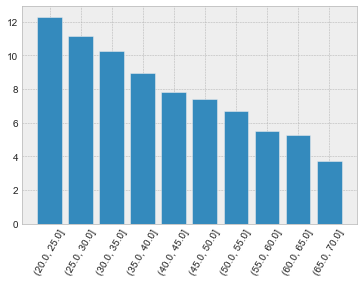

In [25]:
# 把target乘100 讓可是化效果更好
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])
plt.xticks(rotation=60)
plt.show()

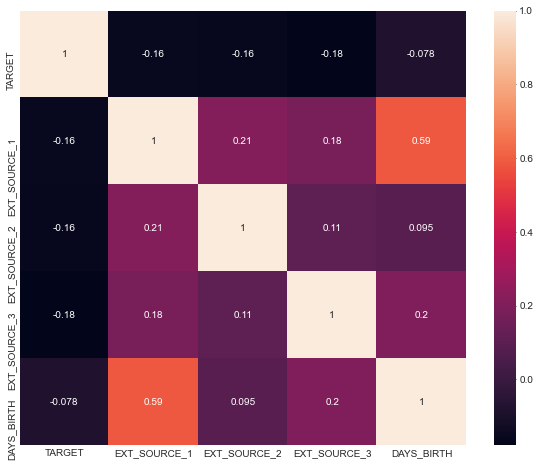

In [26]:
# 針對 target 跟 剛剛相關性細數最高的三個 做一個 dataframe 再加上年紀
ext_data = X[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(ext_data_corrs, annot=True)
plt.show()

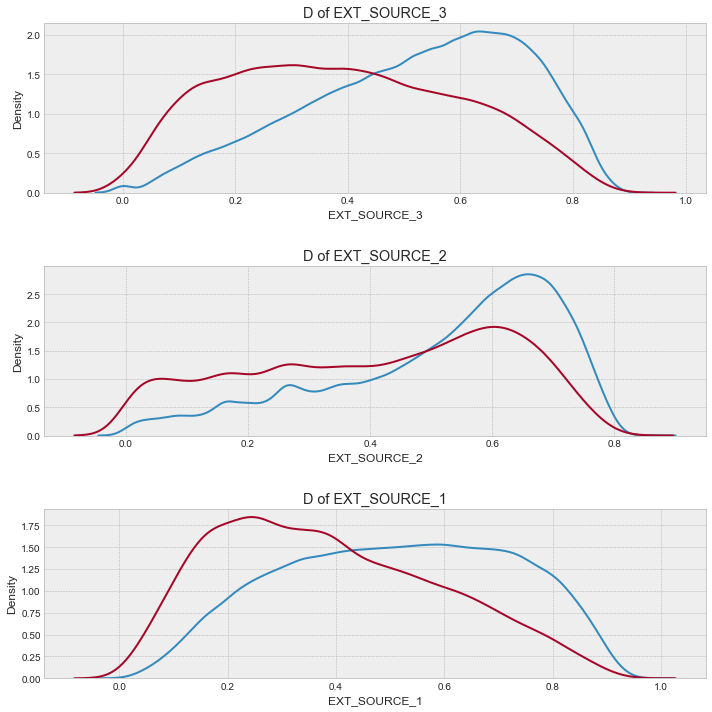

In [27]:
plt.figure(figsize=(10,10))

# enumerate 列舉 ==> i :index ; source: 內容
for i, source in enumerate(['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']):
    # 指定好子圖的位置 
    plt.subplot(3, 1, i+1)
    
    # kdeplot
    sns.kdeplot(X.loc[X['TARGET']==0, source], label='target==0')
    sns.kdeplot(X.loc[X['TARGET']==1, source], label='target==1')
    plt.title('D of %s' % source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

# 藍線:0 紅線:1

### 特徵工程
- 創建新特徵

In [28]:
# 信用額度與薪資比值
X['CREDIT_INCOME_PERCENT'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']

# 
X['ANNUITY_INCOME_PERCENT'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']

# 還款總月份
X['CREDIT_TERM'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']

# 上班時間與年齡的比值
X['DAYS_EMPLOYED_PERCENT'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']

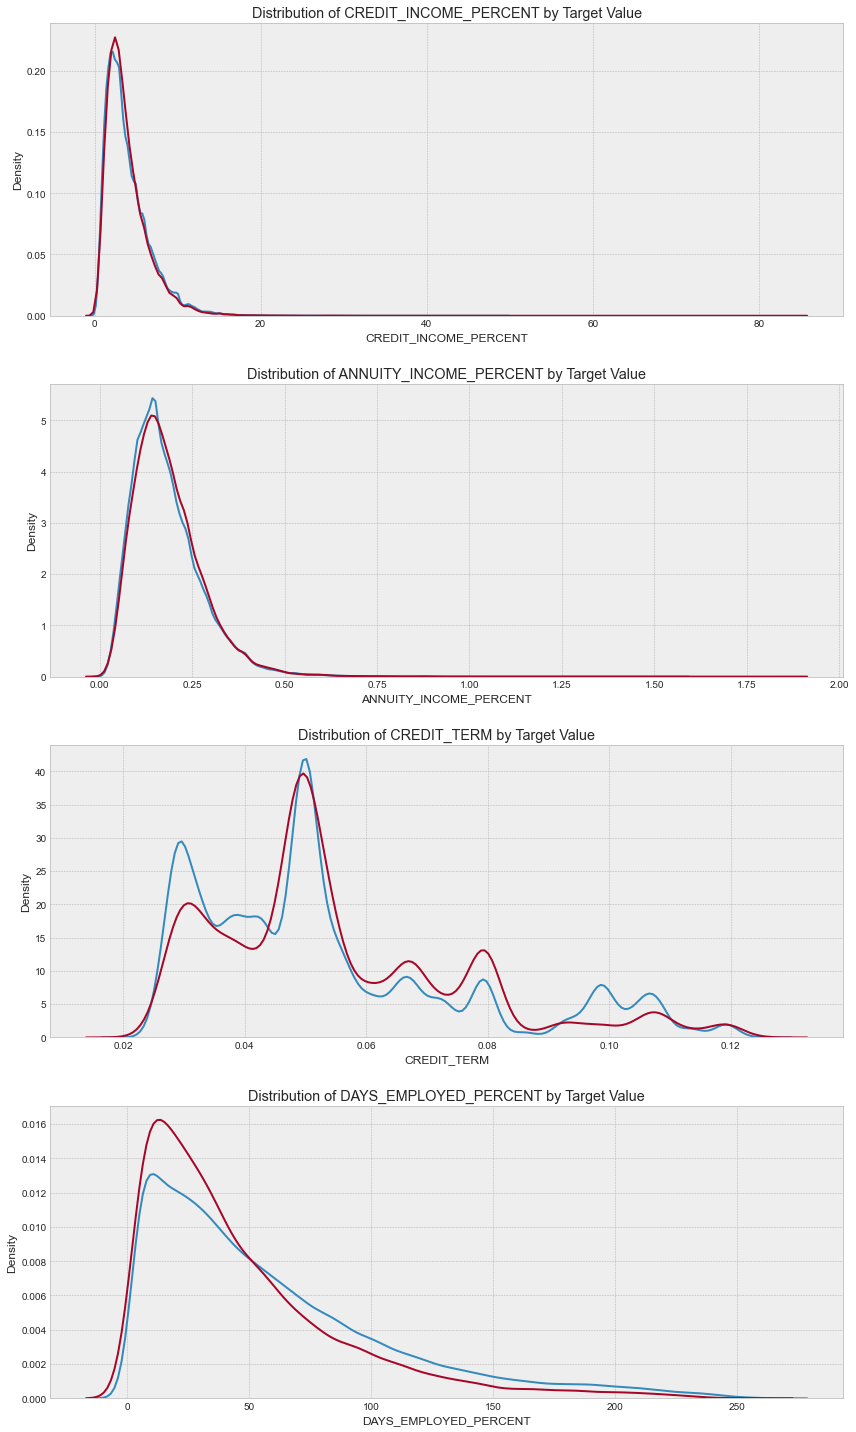

In [29]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(X.loc[X['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(X.loc[X['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.show()

### 數據前處理
- 使用 ROC_AUC 驗證時, 餵進去的參數要是機率, 不要是 TRUE/FALSE

In [30]:
train = X[:train.shape[0]]
y_train = np.ravel(y_train)
test = X[train.shape[0]:]

train = train.drop(columns=['TARGET'])
test = test.drop(columns=['TARGET'])

print(f'X_train shape: {train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {test.shape}')

X_train shape: (307511, 247)
y_train shape: (307511,)
X_test shape: (48744, 247)


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # 用來填充缺失值

# 使用 中位數 填補缺失值
imputer = SimpleImputer(strategy='median')

# fit一定是 fit train
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

# 標準化
std = StandardScaler()
# fit一定是 fit train
std.fit(train)
train = std.transform(train)
test = std.transform(test)

#### 邏輯回歸
- 使用原始數據

In [403]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.0001) # 數字越小 , 懲罰越大
log_reg.fit(train, y_train)

#predictions = log_reg.predict(test) # predict直接返回 true/false 結果 , 利用 0.5進行判斷分類
predictions = log_reg.predict_proba(train)[:,1] # 返回預測機率結果 # 機率有兩個 是或不是個有機率, 所以用 [:,1]

#  測試一下訓練結果 AUC 越接近 1 越好
train_auc = roc_auc_score(y_train, predictions)
train_auc

0.7461177486442653

#### 隨機森林
- 使用原始數據

In [404]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=300,random_state=10,n_jobs=-1)
random_forest.fit(train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=10)

In [405]:
#predictions = random_forest.predict(test)
predictions = random_forest.predict_proba(train)[:,1]
train_auc = roc_auc_score(y_train, predictions)
train_auc

1.0

#### LightGBM
- n_estimators : 建立多少樹
- objective = 'binary' : 目標為二分類
- class_weight
- learning_rate
- reg_alpha : 
- reg_lambda
- subsample
- n_jobs
- random_state

In [406]:
import lightgbm as lgb


# model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
#                                    class_weight = 'balanced', learning_rate = 0.001, 
#                                    reg_alpha = 0.1, reg_lambda = 0.1, 
#                                    subsample = 0.8, n_jobs = -1, random_state = 100)

model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                           class_weight = 'balanced', learning_rate = 0.001, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 50)

# 使用 AUC 來驗證
# model.fit(train, y_train, eval_metric = 'auc', eval_set = [(test, y_test), (train, y_train)],
#           eval_names = ['test', 'train'], early_stopping_rounds = 100, verbose = 20)

model.fit(train, y_train)
predictions = model.predict_proba(train)[:,1]
train_auc = roc_auc_score(y_train, predictions)
train_auc

0.7961460751711824

In [407]:
lgb_pred = model.predict_proba(test)[:,1]

In [408]:
sub = pd.read_csv('./data/Home Credit Default Risk/sample_submission.csv')
submission = pd.DataFrame()
submission['SK_ID_CURR'] = sub['SK_ID_CURR']
submission['TARGET'] = lgb_pred 
submission.to_csv('./data/Home Credit Default Risk/submission_result.csv', index = False)